In [1]:
# AC-GAN (Auxiliary Classifier GAN)
#
# What's Special About AC-GAN?
# Regular GANs just ask the Discriminator:
# “Is this image real or fake?”

# AC-GAN adds another job for the Discriminator:
# “Also, tell me the class of the image (like digit 0–9 in MNIST)!”

#So the Discriminator has two outputs:
# Real or Fake (Adversarial loss)
# Which Class (Classification loss)


#Why Do We Add Class Labels?
#Adding the label helps both players:

#Generator learns how to create a specific type of image (e.g., digit 5).
#Discriminator becomes smarter by not just spotting fakes but also understanding what the image is.

#This makes training more stable and generation more controlled. You can say:
#“Give me a fake digit 3” and the Generator will do just that.

#How It Works (Step-by-step)
#Input to Generator: Random noise + class label (e.g., “digit 3”)
#Output: A fake image that looks like digit 3.

#Input to Discriminator: Real and fake images.
#Output from Discriminator: Probability of being real or fake & Predicted class (0–9)

#Two types of loss used:

#Adversarial Loss: Fool the Discriminator (GAN-style)
#Auxiliary Loss: Predict correct class label

#Key Benefits of AC-GAN
#You can control what to generate (digit 7, shoe, face, etc.)

#The model becomes more stable and often performs better

#Useful in conditional generation tasks (generate X from class Y)

In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Hyperparameters
latent_dim = 100 #analogy: number of principle components (random noise)
num_classes = 10
img_shape = (1, 28, 28)
batch_size = 64
epochs = 100
lr = 0.0002
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# DataLoader
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])
dataset = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9912422/9912422 [00:04<00:00, 2448614.93it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28881/28881 [00:00<00:00, 251105.79it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1648877/1648877 [00:00<00:00, 1965918.63it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4542/4542 [00:00<00:00, 4405765.21it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        # Embedding layer to convert class labels (0-9) into vectors
        self.label_emb = nn.Embedding(num_classes, num_classes)

        # Fully connected layers for generator
        self.model = nn.Sequential(
            nn.Linear(latent_dim + num_classes, 128),  # input: noise + label
            nn.LeakyReLU(0.2),                          # activation function

            nn.Linear(128, 256),                        # hidden layer
            nn.BatchNorm1d(256),                        # normalize for stable training
            nn.LeakyReLU(0.2),

            nn.Linear(256, 512),                        # deeper layer
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),

            nn.Linear(512, int(np.prod(img_shape))),    # final output layer
            nn.Tanh()                                   # scale output between [-1, 1]
        )

    def forward(self, noise, labels):
        # Concatenate noise and embedded label
        input = torch.cat((noise, self.label_emb(labels)), -1)

        # Pass through the generator network
        img = self.model(input)

        # Reshape the output to image shape (1, 28, 28)
        img = img.view(img.size(0), *img_shape)
        return img


In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        # Shared layers for both adversarial (real/fake) and auxiliary (class) output
        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),  # flatten input image
            nn.LeakyReLU(0.2),

            nn.Linear(512, 256),
            nn.LeakyReLU(0.2)
        )

        # Output: Real/Fake probability (single unit, no activation here)
        self.adv_layer = nn.Linear(256, 1)

        # Output: Class prediction (10 classes)
        self.aux_layer = nn.Linear(256, num_classes)

    def forward(self, img):
        # Flatten image to vector (batch_size, 28*28)
        img_flat = img.view(img.size(0), -1)

        # Shared representation
        out = self.model(img_flat)

        # Real/fake output (adversarial)
        validity = self.adv_layer(out)

        # Class label prediction (auxiliary)
        label = self.aux_layer(out)

        return validity, label


In [ ]:
# Initialize models
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# # Load the existing model and continue training
# discriminator.load_state_dict(torch.load('acgan_discriminator.pth', map_location=torch.device('cpu')))
# generator.load_state_dict(torch.load('acgan_generator.pth', map_location=torch.device('cpu')))


In [8]:
# Loss functions
adversarial_loss = nn.BCEWithLogitsLoss()
auxiliary_loss = nn.CrossEntropyLoss()

In [9]:
# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))


In [10]:
# Training
for epoch in range(epochs):
    for i, (imgs, labels) in enumerate(dataloader):

        real_imgs = imgs.to(device)
        labels = labels.to(device)

        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()

        z = torch.randn(imgs.size(0), latent_dim).to(device)
        gen_labels = torch.randint(0, num_classes, (imgs.size(0),)).to(device)
        gen_imgs = generator(z, gen_labels)

        validity, pred_label = discriminator(gen_imgs)

        g_loss = adversarial_loss(validity, torch.ones_like(validity)) + \
                 auxiliary_loss(pred_label, gen_labels)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        real_pred, real_aux = discriminator(real_imgs)
        d_real_loss = adversarial_loss(real_pred, torch.ones_like(real_pred)) + \
                      auxiliary_loss(real_aux, labels)

        fake_pred, fake_aux = discriminator(gen_imgs.detach())
        d_fake_loss = adversarial_loss(fake_pred, torch.zeros_like(fake_pred)) + \
                      auxiliary_loss(fake_aux, gen_labels)

        d_loss = (d_real_loss + d_fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

    print(f"Epoch [{epoch+1}/{epochs}]  D_loss: {d_loss.item():.4f}  G_loss: {g_loss.item():.4f}")


Epoch [1/100]  D_loss: 0.7241  G_loss: 0.6782
Epoch [2/100]  D_loss: 0.7659  G_loss: 1.8045
Epoch [3/100]  D_loss: 0.8674  G_loss: 1.5282
Epoch [4/100]  D_loss: 0.6465  G_loss: 1.5940
Epoch [5/100]  D_loss: 0.6365  G_loss: 2.4873
Epoch [6/100]  D_loss: 0.7657  G_loss: 0.3778
Epoch [7/100]  D_loss: 0.6199  G_loss: 0.9490
Epoch [8/100]  D_loss: 0.7871  G_loss: 0.9245
Epoch [9/100]  D_loss: 0.4589  G_loss: 1.7792
Epoch [10/100]  D_loss: 0.3304  G_loss: 2.4450
Epoch [11/100]  D_loss: 0.4016  G_loss: 2.1622
Epoch [12/100]  D_loss: 0.4205  G_loss: 1.7765
Epoch [13/100]  D_loss: 0.3604  G_loss: 1.1771
Epoch [14/100]  D_loss: 0.3643  G_loss: 1.2142
Epoch [15/100]  D_loss: 0.3742  G_loss: 1.0747
Epoch [16/100]  D_loss: 0.3558  G_loss: 1.1362
Epoch [17/100]  D_loss: 0.3023  G_loss: 2.1087
Epoch [18/100]  D_loss: 0.5771  G_loss: 1.7307
Epoch [19/100]  D_loss: 0.3611  G_loss: 4.1995
Epoch [20/100]  D_loss: 0.5634  G_loss: 4.4046
Epoch [21/100]  D_loss: 0.3394  G_loss: 1.0738
Epoch [22/100]  D_loss

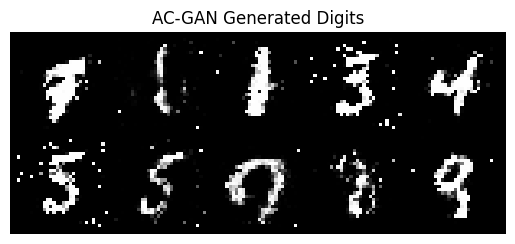

In [11]:
# Save Sample Images
def show_sample():
    z = torch.randn(10, latent_dim).to(device)
    labels = torch.arange(0, 10).to(device)
    gen_imgs = generator(z, labels).detach().cpu()

    grid = torchvision.utils.make_grid(gen_imgs, nrow=5, normalize=True)
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.title("AC-GAN Generated Digits")
    plt.axis("off")
    plt.show()

show_sample()

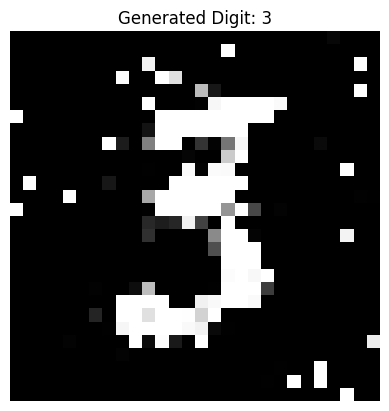

In [12]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Switch generator to evaluation mode
generator.eval()

# Choose class label for prediction (e.g., digit 3)
target_label = torch.tensor([3]).to(device)

# Generate random noise vector
z = torch.randn(1, latent_dim).to(device)

# Generate image
with torch.no_grad():
    gen_img = generator(z, target_label)

# Unnormalize and plot
def show_generated_image(img_tensor):
    img = img_tensor.squeeze().cpu().numpy()
    img = (img + 1) / 2  # Rescale from [-1,1] to [0,1]
    plt.imshow(img, cmap="gray")
    plt.title(f"Generated Digit: {target_label.item()}")
    plt.axis("off")
    plt.show()

show_generated_image(gen_img)


In [ ]:
# Save generator and discriminator
torch.save(generator.state_dict(), "acgan_generator.pth")
torch.save(discriminator.state_dict(), "acgan_discriminator.pth")


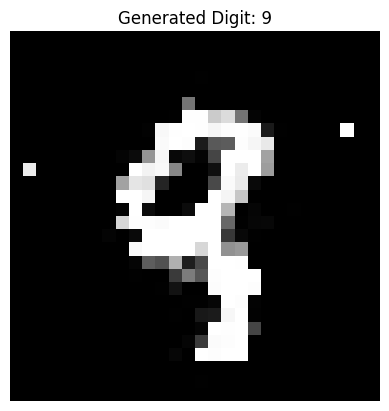

In [ ]:
# Recreate model architecture
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Load weights
generator.load_state_dict(torch.load("acgan_generator.pth"))
discriminator.load_state_dict(torch.load("acgan_discriminator.pth"))


# Switch to evaluation mode
generator.eval()
discriminator.eval()

## Generate digit
digit=9
label = torch.tensor([digit]).to(device)
noise = torch.randn(1, latent_dim).to(device)

with torch.no_grad():
    gen_img = generator(noise, label)

# Visualize
import matplotlib.pyplot as plt
plt.imshow(gen_img.squeeze().cpu().numpy(), cmap="gray")
plt.title(f"Generated Digit: {digit}")
plt.axis("off")
plt.show()
